## Binary VAE para Hash
#### Francisco Mena
Basado en:
* https://github.com/EderSantana/gumbel/
* https://github.com/EmilienDupont/vae-concrete
> ### Binary Variational Semantic Hashing


In [1]:
import numpy as np
import keras
from keras.layers import *
from keras.models import Sequential,Model
from keras import backend as K
import matplotlib.pyplot as plt
import seaborn as sns

from base_networks import *

Using TensorFlow backend.


In [2]:
#random data
X = np.random.rand(10000,5000)
X.shape

(10000, 5000)

In [15]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [35]:
def traditional_VAE(data_dim,Nb,units,layers_e,layers_d,opt='adam'):
    pre_encoder = define_pre_encoder(data_dim, layers=layers_e,units=units)
    print("pre-encoder network:")
    pre_encoder.summary()
    
    generator = define_generator(Nb,data_dim,layers=layers_d,units=units)
    print("generator network:")
    generator.summary()
    
    ## Encoder
    x = Input(shape=(data_dim,))
    hidden = pre_encoder(x)
    z_mean = Dense(Nb,activation='linear', name='z-mean')(hidden)
    z_log_sigma = Dense(Nb,activation='linear',name = 'z-log_sigma')(hidden)
    encoder = Model(x, z_mean) # build a model to project inputs on the latent space

    def sampling(args):
        epsilon_std = 1.0
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], Nb),mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_sigma) * epsilon #+sigma (desvest)
    
    ## Decoder
    z_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')([z_mean, z_log_sigma])
    output = generator(z_sampled)

    def vae_loss(x, x_hat):
        reconstruction_loss = keras.losses.categorical_crossentropy(x, x_hat)*data_dim 
        #reconstruction_loss = keras.losses.binary_crossentropy(x, x_hat)*data_dim 

        kl_loss = - 0.5 * K.sum(1 + 2*z_log_sigma - K.square(z_mean) - K.square(K.exp(z_log_sigma)), axis=-1) #con varianza
        return K.mean(reconstruction_loss  + kl_loss) #ya que kl es suma K.mean()

    traditional_vae = Model(x, output)
    traditional_vae.compile(optimizer=opt,loss=vae_loss)
    return traditional_vae

traditional_vae = traditional_VAE(5000,512,16)
traditional_vae.summary()

TypeError: traditional_VAE() missing 2 required positional arguments: 'layers_e' and 'layers_d'

In [39]:
batch_size = 100
epochs = 100
traditional_vae = traditional_VAE(x_train.shape[1],Nb=32,units=256,layers_e=1,layers_d=1)
traditional_vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size)

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 256)               200960    
Total params: 200,960
Trainable params: 200,960
Non-trainable params: 0
_________________________________________________________________
1
generator network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 256)               8448      
_________________________________________________________________
dense_70 (Dense)             (None, 784)               201488    
Total params: 209,936
Trainable params: 209,936
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
60000/60000 [==============================] - 6s 92us/step - loss: 424556.0888
Epoch 2/100
60000/60000 [==============================] - 4s 

KeyboardInterrupt: 

In [59]:
data_dim = x_train.shape[1]
layers_e = 1
layers_d = 1
units = 256
Nb = 32 #Number of bits
opt= 'adam'

#def traditional_VAE(data_dim,Nb,units,layers_e,layers_d,opt='adam'):
pre_encoder = define_pre_encoder(data_dim, layers=layers_e,units=units)
print("pre-encoder network:")
pre_encoder.summary()

generator = define_generator(Nb,data_dim,layers=layers_d,units=units)
print("generator network:")
generator.summary()
    

tau = K.variable(5.0, name="temperature") #hay que setearlo..

x = Input(shape=(data_dim,))
hidden = pre_encoder(x)
logits_b  = Dense(Nb, activation='linear', name='logits-b')(hidden) #log(p(b)/1-p(b))
#proba = np.exp(logits_b)/(1+np.exp(logits_b)) = sigmoidal(logits_b) <<<<<<<<<< recuepra probabilidad

#dist = Dense(Nb, activation='sigmoid')(hidden) #p(b)

encoder = Model(x, logits_b)

def sample_gumbel(shape,eps=K.epsilon()):
    """Inverse Sample function from Gumbel(0, 1)"""
    U = K.random_uniform(shape, 0, 1)
    return K.log(U + eps)- K.log(1-U + eps)
        
def sampling(aux):
    #logits_b = K.log(aux/(1-aux) + K.epsilon() )
    logits_b = aux
    b = logits_b + sample_gumbel(K.shape(logits_b)) # logits + gumbel noise
    return keras.activations.sigmoid( b/tau )

b_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')(logits_b)
output = generator(b_sampled)

#Me tinca que está mal:
def gumbel_loss(x, x_hat):
    reconstruction_loss = keras.losses.categorical_crossentropy(x, x_hat)*data_dim
    
    dist = keras.activations.sigmoid(logits_b) #q(b)
        
    kl_disc_loss = Nb*np.log(2) + K.sum( dist*K.log(dist + K.epsilon()) + (1-dist)* K.log(1-dist + K.epsilon()),axis=1)
    return reconstruction_loss  + kl_disc_loss

binary_vae = Model(x, output)
binary_vae.compile(optimizer=opt, loss=gumbel_loss)
binary_vae.summary()

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_102 (Dense)            (None, 256)               200960    
Total params: 200,960
Trainable params: 200,960
Non-trainable params: 0
_________________________________________________________________
1
generator network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 256)               8448      
_________________________________________________________________
dense_104 (Dense)            (None, 784)               201488    
Total params: 209,936
Trainable params: 209,936
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_81 (InputLayer) 

In [60]:
binary_vae.fit(x_train,x_train,epochs=20)

Epoch 1/20
60000/60000 [==============================] - 14s 241us/step - loss: 430133.7091
Epoch 2/20
60000/60000 [==============================] - 13s 211us/step - loss: 415458.1029
Epoch 3/20
60000/60000 [==============================] - 13s 211us/step - loss: 412067.7339
Epoch 4/20
60000/60000 [==============================] - 13s 211us/step - loss: 410127.5774
Epoch 5/20
60000/60000 [==============================] - 13s 212us/step - loss: 408833.8265
Epoch 6/20
60000/60000 [==============================] - 13s 211us/step - loss: 407926.5176
Epoch 7/20
60000/60000 [==============================] - 13s 212us/step - loss: 407283.1832
Epoch 8/20
60000/60000 [==============================] - 13s 210us/step - loss: 406779.0565
Epoch 9/20
51360/60000 [========================>.....] - ETA: 1s - loss: 406596.8077

KeyboardInterrupt: 

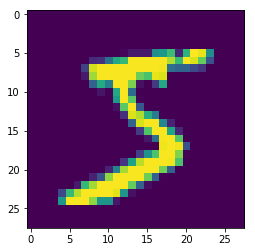

In [56]:
plt.imshow(x_train[0].reshape(28,28))

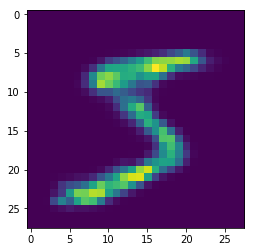

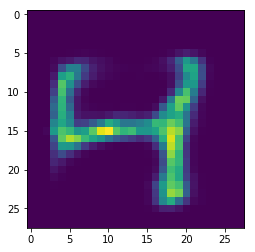

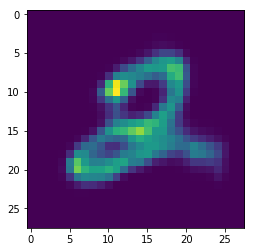

In [61]:
predict_x = binary_vae.predict(x_train)
plt.imshow(predict_x[0].reshape(28,28))
plt.show()
plt.imshow(predict_x[2].reshape(28,28))
plt.show()
plt.imshow(predict_x[5].reshape(28,28))

In [100]:
U = K.random_uniform((8,), 0, 1)
U.eval(session=K.get_session())

array([0.9292773 , 0.65858245, 0.91319764, 0.16799355, 0.14256966,
       0.25475013, 0.01682949, 0.86192214], dtype=float32)

In [31]:
#obtener probabilidades de codigos binarios
logits = encoder.predict(X[:1000])
probas = keras.activations.sigmoid(logits).eval(session=K.get_session())
probas

array([[0.43783456, 0.29870096, 0.6656069 , ..., 0.6301294 , 0.77129394,
        0.18610832],
       [0.37131384, 0.31683958, 0.55881345, ..., 0.7582314 , 0.7540688 ,
        0.2598843 ],
       [0.33411175, 0.40805054, 0.44053924, ..., 0.65402764, 0.7095646 ,
        0.18874496],
       ...,
       [0.37332126, 0.33784363, 0.6420201 , ..., 0.76295245, 0.7818115 ,
        0.19926082],
       [0.35585272, 0.41265407, 0.5599596 , ..., 0.62157196, 0.7591367 ,
        0.17027016],
       [0.468956  , 0.3313979 , 0.5188709 , ..., 0.68151903, 0.6636331 ,
        0.13369915]], dtype=float32)

In [94]:
#generar la distribucion de probabildiad dado un codigo binario
#dada una probabilidad sobre el codigo
proba_b = np.random.rand(2,Nb)
b = sampling(proba_b).eval(session=K.get_session())

#dado un codigo binario
#b = np.ones((2,Nb))

reconstruct_data = generator.predict(b)
reconstruct_data

array([[0.0001948 , 0.00020341, 0.00020224, ..., 0.00019884, 0.00019546,
        0.00020585],
       [0.00019493, 0.00020488, 0.0002041 , ..., 0.00019809, 0.00019341,
        0.00020736]], dtype=float32)

In [41]:
batch_size = 100
epochs = 100
binary_vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size)

Epoch 1/100
60000/60000 [==============================] - 6s 93us/step - loss: nan
Epoch 2/100
20500/60000 [=========>....................] - ETA: 2s - loss: nan

KeyboardInterrupt: 